In [5]:
import pandas as pd
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 40,
    "figure.figsize":(13,8),
    "lines.markersize": 20
})
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [14]:
model_labels={'meta-llama/Llama-3.1-8B-Instruct':'8B',
              'meta-llama/Llama-3.1-8q-Instruct':'bnb-8bit',
                'meta-llama/Llama-3.1-4q-Instruct':'bnb-4bit',
              'hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4':'AWQ-INT4',
              'meta-llama/Llama-3.2-3B-Instruct':'3B',
              'meta-llama/Llama-3.2-1B-Instruct':'1B'
}

### Read pairwise comparison data

In [52]:
models_full=['meta-llama/Llama-3.1-8B-Instruct',
             'meta-llama/Llama-3.1-8q-Instruct',
             'meta-llama/Llama-3.1-4q-Instruct',
             'hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4',
             'meta-llama/Llama-3.2-3B-Instruct',
             'meta-llama/Llama-3.2-1B-Instruct']
output_dir=f'../outputs/LMSYS/'

clean_different=pd.read_json(f'{output_dir}independent_comparisons.json')
clean_shared=pd.read_json(f'{output_dir}coupled_comparisons.json')

# for queries that were asked in reverse model order, switch winner/models/seeds to match original order
def swap_order(row):
    if models_full.index(row['model_a']) > models_full.index(row['model_b']):
        row['winner'] = 'A' if row['winner'] == 'B' else 'B' if row['winner'] == 'A' else row['winner']
        row['seed_a'], row['seed_b'] = row['seed_b'], row['seed_a']
        row['model_a'], row['model_b'] = row['model_b'], row['model_a']
    return row

clean_different_set=clean_different.apply(swap_order,axis=1)
clean_shared_set=clean_shared.apply(swap_order,axis=1)

### Ties per pair of models

### Compute win-rates and rank-sets

Code to compute rank-sets based on [Prediction-Powered Ranking of Large Language Models](https://github.com/Networks-Learning/prediction-powered-ranking).

In [16]:
def summarize_dataset(models, dataset):
    n = len(dataset['winner'])
    
    winner1_llm = np.zeros(shape=(n,1))
    winner2_llm = np.zeros(shape=(n,1))
    model_a_matrix = np.zeros(shape=(len(models),n))
    model_b_matrix = np.zeros(shape=(len(models),n))
    
    for i in range(n):        
        if dataset['winner'][i] == 'A':
            winner1_llm[i] = 1
        elif dataset['winner'][i] == 'B':
            winner2_llm[i] = 1
        
        model_a_matrix[models.index(dataset['model_a'][i])][i] = 1
        model_b_matrix[models.index(dataset['model_b'][i])][i] = 1
    
    summarized = {'winner1_predicted':winner1_llm,
                  'winner2_predicted':winner2_llm,
                  'model_a_matrix': model_a_matrix,
                  'model_b_matrix': model_b_matrix}
        
    return summarized

def sample_avg(k, Dn):
    n = np.shape(Dn['model_a_matrix'])[1]
    M1, M2 = Dn['model_a_matrix'], Dn['model_b_matrix']
    w1, w2 = Dn['winner1_predicted'], Dn['winner2_predicted']
    
    a = np.matmul(np.ones((k,1)), np.transpose(np.matmul(
        M1+M2,np.ones((n,1))))) *np.identity(k)
    for i in range(k):
        a[i][i] = 1/a[i][i]
    a = np.matmul(a,np.matmul(M1,w1) + np.matmul(M2,w2))
    
    A = np.matmul(np.ones((k,1)), np.transpose(
        w1 - np.matmul(np.transpose(M1) ,a)))*M1
    A += np.matmul(np.ones((k,1)), 
                   np.transpose(w2 - np.matmul(np.transpose(M2), a)))*M2
    
    Sigma = (np.matmul(A, np.transpose(A)))/(n**2)
    
    return a, Sigma

import scipy.stats as stats

def find_ranksets(k, thetahat, Sigma, alpha=0.05):
    lhat = np.ones((k,1))
    uhat = np.ones((k,1))*k
    
    assert alpha>0 and alpha<1, 'alpha must be between 0 and 1'
    
    for m1 in range(k):
        for m2 in range(k):
            if m1 == m2:
                continue
            d = abs(thetahat[m1] - thetahat[m2])/np.sqrt(2) - \
            np.sqrt((Sigma[m1][m1] + Sigma[m2][m2] - 2*Sigma[m1][m2])*\
                    (stats.chi2.ppf(1-alpha,k)/(2)))
            if d > 0 and thetahat[m1] < thetahat[m2]:
                lhat[m1] += 1
            elif d > 0 and thetahat[m1] > thetahat[m2]:
                uhat[m1] -= 1
    
    return [[int(lhat[m][0]), int(uhat[m][0])] for m in range(k)]

### Pairwise win-rates

In [46]:
def compute_pairwise_winrates(df,models):
    winrates=dict()
    ci=dict()
    for m1 in range(len(models)):
        for m2 in range(m1+1,len(models)):
            wins_A=len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2]) & (df['winner'] == 'A')])
            wins_B=len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2]) & (df['winner'] == 'B')])
            winrates[(models[m1],models[m2])]=wins_A/len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2])])
            winrates[(models[m2],models[m1])]=wins_B/len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2])])
        
            ci[(models[m1],models[m2])]=1.96*np.sqrt(winrates[(models[m1],models[m2])]*(1-winrates[(models[m1],models[m2])])/len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2])]))
            ci[(models[m2],models[m1])]=1.96*np.sqrt(winrates[(models[m2],models[m1])]*(1-winrates[(models[m2],models[m1])])/len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2])]))
    return winrates,ci

p_w_s,ci_s=compute_pairwise_winrates(clean_shared_set,models_full)
p_w_d,ci_d=compute_pairwise_winrates(clean_different_set,models_full)

### Ties per pair of models

In [47]:
# Count number of ties per pair of models
def compute_ties(df,models):
    ties=[[0 for _ in range(len(models))] for _ in range(len(models))]
    for m1 in range(len(models)):
        for m2 in range(m1,len(models)):
            if m1==m2:
                ties[m1][m2]=0
            ties[m1][m2]=len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2]) & (df['winner'] == 'Tie')])
            ties[m2][m1]=len(df[(df['model_a'] == models[m1]) & (df['model_b'] == models[m2]) & (df['winner'] == 'Tie')])
    return ties

ties_different=compute_ties(clean_different_set,models_full)
ties_shared=compute_ties(clean_shared_set,models_full)

# compute relative increase in ties under shared noise compared to different noise
ties_diff=[[0 for j in range(len(models_full))] for i in range(len(models_full))]
for i in range(len(models_full)):
    for j in range(len(models_full)):
        if i==j:
            continue
        ties_diff[i][j]=100*(ties_shared[i][j]-ties_different[i][j])/ties_different[i][j]
print(ties_diff)

[[0, 23.544411389715258, 8.442694663167105, 8.388520971302428, 1.9928461931527848, 2.3424878836833605], [23.544411389715258, 0, 11.326097215667767, 14.729064039408867, 5.224274406332454, -2.6548672566371683], [8.442694663167105, 11.326097215667767, 0, 5.865657521286661, 3.3157894736842106, -0.14803849000740193], [8.388520971302428, 14.729064039408867, 5.865657521286661, 0, -1.2833675564681726, 6.031746031746032], [1.9928461931527848, 5.224274406332454, 3.3157894736842106, -1.2833675564681726, 0, 7.341269841269841], [2.3424878836833605, -2.6548672566371683, -0.14803849000740193, 6.031746031746032, 7.341269841269841, 0]]


## Figures 3,6 and Table 1

In [50]:
def hypothesis_test_pairwise(dfs,dfd,models,m1,m2):
    count_s=len(dfs[(dfs['model_a']==models[m1]) & (dfs['model_b']==models[m2])])
    count_s+=len(dfs[(dfs['model_a']==models[m2]) & (dfs['model_b']==models[m1])])

    count_d=len(dfd[(dfd['model_a']==models[m1]) & (dfd['model_b']==models[m2])])
    count_d+=len(dfd[(dfd['model_a']==models[m2]) & (dfd['model_b']==models[m1])])

    win_s=len(dfs[(dfs['model_a'] == models[m1]) & (dfs['model_b'] == models[m2]) & (dfs['winner'] == 'A')])
    win_s+=len(dfs[(dfs['model_a'] == models[m2]) & (dfs['model_b'] == models[m1]) & (dfs['winner'] == 'B')])

    win_d=len(dfd[(dfd['model_a'] == models[m1]) & (dfd['model_b'] == models[m2]) & (dfd['winner'] == 'A')])
    win_d+=len(dfd[(dfd['model_a'] == models[m2]) & (dfd['model_b'] == models[m1]) & (dfd['winner'] == 'B')])

    p_s=win_s/count_s
    p_d=win_d/count_d

    p=(win_s+win_d)/(count_s+count_d)
    z=(p_s-p_d)/np.sqrt(p*(1-p)*(1/count_s+1/count_d))

    p_value = scipy.stats.norm.sf(abs(z))*2
    if p_value<0.0001:
        return '****'
    if p_value<0.001:
        return '***'
    if p_value<0.01:
        return '**'
    if p_value<0.05:
        return '*'
    else:
        return 'ns'

# figure 3
def plot_pairwise_winrates_barplot(p_w_s,ci_s,p_w_d,ci_d,models_full,model):
    fig, ax = plt.subplots(figsize=(12,6))
    labels=[model_labels[m] for m in models_full if m != model]
    winrates_shared={model_labels[m]:p_w_s[(model,m)] for m in models_full if m != model}
    ci_shared={model_labels[m]:ci_s[(model,m)] for m in models_full if m != model}
    winrates_different={model_labels[m]:p_w_d[(model,m)] for m in models_full if m != model}
    ci_different={model_labels[m]:ci_d[(model,m)] for m in models_full if m != model}
    x=np.arange(len(labels))
    ax.bar(x-0.15, winrates_shared.values(), width=0.3, label='Coupled', color='teal',alpha=0.8)
    ax.bar(x+0.15, winrates_different.values(), width=0.3, label='Independent', color='palevioletred',alpha=0.8)
    
    ax.errorbar(x-0.15, winrates_shared.values(), yerr=ci_shared.values(), fmt='none', ecolor='black', capsize=5)
    ax.errorbar(x+0.15, winrates_different.values(), yerr=ci_different.values(), fmt='none', ecolor='black', capsize=5)

    for m in range(len(models_full)):
        if models_full[m]==model:
            continue
        annot=hypothesis_test_pairwise(clean_shared_set,clean_different_set,models_full,models_full.index(model),m)
        if annot!='ns':
            y_star=max(winrates_shared[model_labels[models_full[m]]]+ci_shared[model_labels[models_full[m]]],winrates_different[model_labels[models_full[m]]]+ci_different[model_labels[models_full[m]]])
            x_star=m
            if models_full.index(model) <m:
                x_star-=1
            ax.plot([x_star-0.2, x_star-0.2, x_star+0.2, x_star+0.2], [y_star+0.02, y_star+0.04, y_star+0.04, y_star+0.02], lw=1.5, c='k')
            ax.text(x_star-0.05*len(annot),y_star+0.03,annot,fontsize=30)

    ax.set_xticks(x)
    ax.set_xlim(-0.5,len(labels)-0.5)
    ax.set_xticklabels(labels, rotation=35,ha='right',rotation_mode='anchor')
    ax.set_ylabel(f'Win-rate')
    ax.spines[['top','right']].set_visible(False)
    ax.legend(frameon=False,ncol=2,loc='upper center',bbox_to_anchor=(0.5,1.05))
    folder_path = '../figures/LMSYS/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    fig.savefig(f'../figures/LMSYS/pairwise_winrates_{model_labels[model]}.pdf',bbox_inches='tight')
    plt.show()

# figure 6
def plot_pairwise_winrates_all(p_w_s,ci_s,p_w_d,ci_d,models):
    fig,ax=plt.subplots(3,2,figsize=(20,20),sharey=True)
    # fig.tight_layout()
    fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
    ax=ax.flatten()
    for i in range(len(models)):
        labels=[model_labels[m] for m in models if m != models[i]]
        x=np.arange(len(labels))

        winrates_shared={model_labels[m]:p_w_s[(models[i],m)] for m in models if m != models[i]}
        ci_shared={model_labels[m]:ci_s[(models[i],m)] for m in models if m != models[i]}
        winrates_different={model_labels[m]:p_w_d[(models[i],m)] for m in models if m != models[i]}
        ci_different={model_labels[m]:ci_d[(models[i],m)] for m in models if m != models[i]}

        ax[i].bar(x-0.15, winrates_shared.values(), width=0.3, label='Coupled', color='teal',alpha=0.8)
        ax[i].bar(x+0.15, winrates_different.values(), width=0.3, label='Independent', color='palevioletred',alpha=0.8)
        
        ax[i].errorbar(x-0.15, winrates_shared.values(), yerr=ci_shared.values(), fmt='none', ecolor='black', capsize=5)
        ax[i].errorbar(x+0.15, winrates_different.values(), yerr=ci_different.values(), fmt='none', ecolor='black', capsize=5)

        for m in range(len(models_full)):
                if models_full[m]==models[i]:
                    continue
                annot=hypothesis_test_pairwise(clean_shared_set,clean_different_set,models_full,models_full.index(models[i]),m)
                if annot!='ns':
                    y_star=max(winrates_shared[model_labels[models_full[m]]]+ci_shared[model_labels[models_full[m]]],winrates_different[model_labels[models_full[m]]]+ci_different[model_labels[models_full[m]]])
                    x_star=m
                    if models_full.index(models[i]) <m:
                        x_star-=1
                    ax[i].plot([x_star-0.2, x_star-0.2, x_star+0.2, x_star+0.2], [y_star+0.02, y_star+0.04, y_star+0.04, y_star+0.02], lw=1.5, c='k')
                    ax[i].text(x_star-0.055*len(annot),y_star+0.05,annot,fontsize=25)

        if i%2==0:
            ax[i].set_ylabel('Win-rate')
            ax[i].set_ylim(0,0.76)
            ax[i].set_yticks([0,0.25,0.5,0.75])
        ax[i].set_title(model_labels[models[i]])
        
        ax[i].set_xlim(-0.5,len(labels)-0.5)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels, rotation=35,ha='right',rotation_mode='anchor')
        ax[i].spines[['top','right']].set_visible(False)
    ax[4].legend(ncol=2,bbox_to_anchor=(1.75,-0.5),frameon=False)
    folder_path = '../figures/LMSYS/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    fig.savefig(f'../figures/LMSYS/pairwise_winrates.pdf',bbox_inches='tight')

    plt.show()


In [ ]:
# compute pairwise win-rates and confidence intervals
p_w_s,ci_s=compute_pairwise_winrates(clean_shared_set,models_full)
p_w_d,ci_d=compute_pairwise_winrates(clean_different_set,models_full)

Figure 3

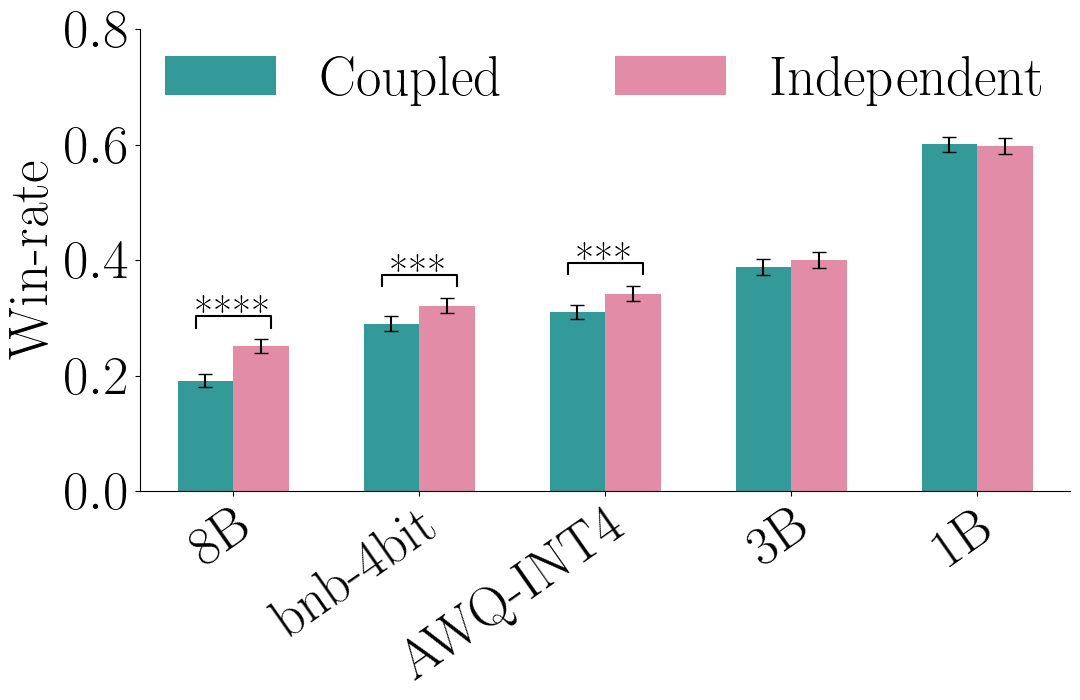

In [32]:
plot_pairwise_winrates_barplot(p_w_s,ci_s,p_w_d,ci_d,models_full,models_full[1])

Figure 6

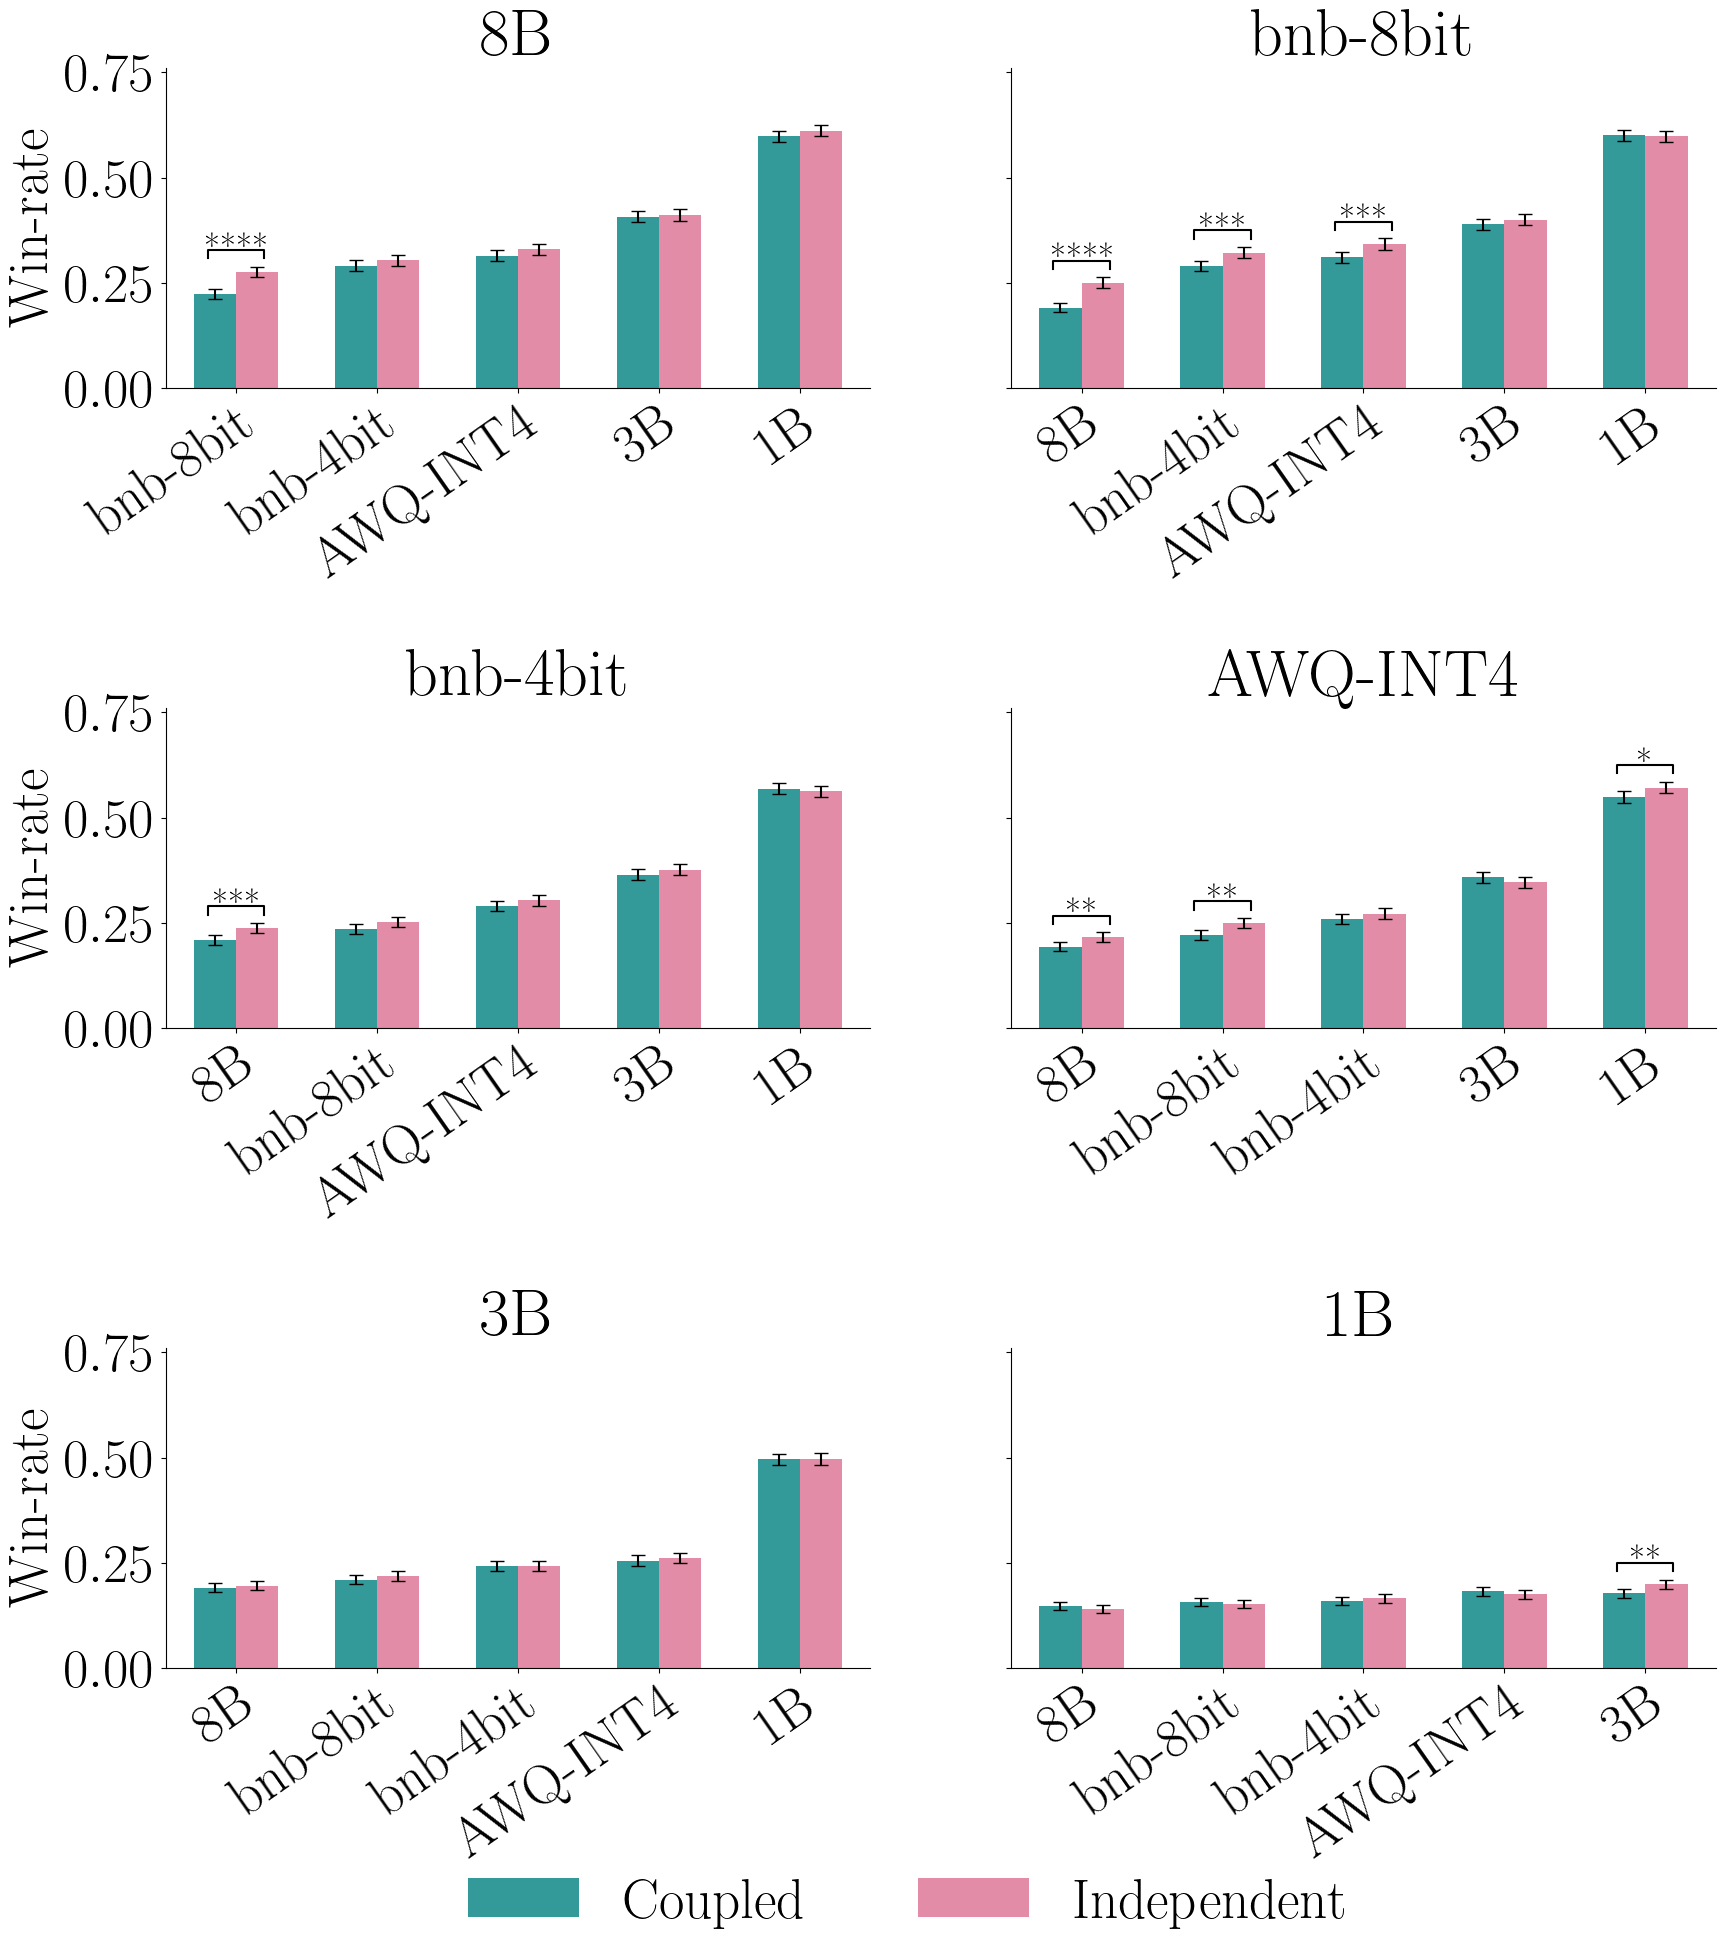

In [51]:
plot_pairwise_winrates_all(p_w_s,ci_s,p_w_d,ci_d,models_full)

Table 1

In [45]:
# compute win-rates and rank-sets under coupled noise
thetahat_shared,Sigma_shared=sample_avg(len(models_full),summarize_dataset(models_full,clean_shared_set.reset_index(drop=True)))
baseline_shared=(find_ranksets(len(models_full), thetahat_shared, Sigma_shared))

# compute win-rates and rank-sets under independent noise
thetahat_different,Sigma_different=sample_avg(len(models_full),summarize_dataset(models_full,clean_different_set.reset_index(drop=True)))
baseline_different=(find_ranksets(len(models_full), thetahat_different, Sigma_different))

# prepare data for table
winrates_shared={models_full[m]:thetahat_shared[m][0] for m in range(len(models_full))}
winrates_different={models_full[m]:thetahat_different[m][0] for m in range(len(models_full))}
cid={models_full[m]:1.96*np.sqrt(Sigma_different[m][m]) for m in range(len(models_full))}
cis={models_full[m]:1.96*np.sqrt(Sigma_different[m][m]) for m in range(len(models_full))}

df=pd.DataFrame()
df['LLM']=model_labels.values()
df['Rank (coupled)']=np.arange(1,len(models_full)+1)
df['Avg. win-rate (coupled)']=thetahat_shared
df['95% CI (coupled)']=[round(1.96*np.sqrt(Sigma_shared[i][i]),4) for i in range(len(models_full))]
df['Rank (independent)']=[1,1,3,4,5,6]
df['Avg win-rate (independent)']=thetahat_different
df['95% CI (independent)']=[round(1.96*np.sqrt(Sigma_different[i][i]),4) for i in range(len(models_full))]
df

,LLM,Rank (coupled),Avg. win-rate (coupled),95% CI (coupled),Rank (independent),Avg win-rate (independent),95% CI (independent)
0,8B,1,0.366959,0.0020,1,0.386281,0.0020
1,bnb-8bit,2,0.356241,0.0020,1,0.382527,0.0020
2,bnb-4bit,3,0.333896,0.0020,3,0.346346,0.0020
3,AWQ-INT4,4,0.316392,0.0019,4,0.330975,0.0019
4,3B,5,0.278687,0.0019,5,0.282831,0.0019
5,1B,6,0.164999,0.0015,6,0.166432,0.0015
